In [14]:
import matplotlib.pyplot as plt
import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.table import QTable

from astroquery.gaia import Gaia

In [15]:
from read_mist_models import ISOCMD

In [16]:
# Gaia Query Parameters

Gaia.MAIN_GAIA_TABLE = "gaiadr2.gaia_source"  # Reselect Data Release 3, default
Gaia.ROW_LIMIT = 10_000

Gaia_cols = [
    'source_id',
    'ra',
    'dec',
    'parallax',
    'parallax_error',
    'pmra',
    'pmdec',
    'radial_velocity',
    'phot_g_mean_mag',
    'phot_bp_mean_mag',
    'phot_rp_mean_mag',
    'bp_rp'
]

In [17]:
iso = ISOCMD('../Data/MIST_iso_HW2.iso.cmd')

age_ind = iso.age_index(8.60) #returns the index for the desired age
B_R = iso.isocmds[age_ind]['Gaia_BP_DR2Rev'] - iso.isocmds[age_ind]['Gaia_RP_DR2Rev']
V = iso.isocmds[age_ind]['Gaia_G_DR2Rev']

Reading in: ../Data/MIST_iso_HW2.iso.cmd


In [18]:
# retrieve NGC 3532 coordinates
NGC3532_Coord = SkyCoord.from_name('NGC 3532')

In [43]:
# Query Gaia DR3 - NGC 3532 (within 0.5 deg)
NGC3532_Query = Gaia.cone_search_async(NGC3532_Coord, radius=0.5*u.deg, columns=Gaia_cols)
NGC3532_Table = NGC3532_Query.get_results()

# only keep stars brighter than G=19 magnitude
NGC3532_Table = NGC3532_Table[NGC3532_Table['phot_g_mean_mag'] < 19*u.mag]

# parallax cut (> 5)
parallax_snr = NGC3532_Table['parallax'] / NGC3532_Table['parallax_error']
NGC3532_Table = NGC3532_Table[parallax_snr > 5]

NGC3532_Table = QTable(NGC3532_Table)


INFO: Query finished. [astroquery.utils.tap.core]


In [44]:
NGC3532_Table

SOURCE_ID,ra,dec,parallax,parallax_error,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,dist
,deg,deg,mas,mas,mas / yr,mas / yr,km / s,mag,mag,mag,mag,
int64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float64
5338663354213056640,166.41335059197613,-58.70603706084505,0.4880292367473344,0.040235513066331836,-7.599583695939771,4.088645939357677,———,15.621060371398926,16.10167694091797,14.944214820861816,1.1574621200561523,0.0021344309822533694
5338663354213054464,166.40819193611284,-58.705479492694955,0.4325731359683008,0.08312675202838589,-3.334412744355741,0.8049482912270783,———,14.87037181854248,15.177971839904785,14.278125762939453,0.899846076965332,0.004829381055413698
5338663354213346048,166.4091169213444,-58.70308163405353,0.5059910389204473,0.03222886237126407,-1.4649950352116075,0.851763049160279,———,14.89655876159668,15.294800758361816,14.300747871398926,0.9940528869628906,0.005675484807773271
5338663354213344000,166.40484612016317,-58.70234663699829,0.8086283904317481,0.08896929334187081,-7.288537822831912,4.968575070938819,———,16.610517501831055,16.916044235229492,15.823101043701172,1.0929431915283203,0.00785112593690732
5338663319853305472,166.40464938920283,-58.712294389892115,0.43502090441780344,0.07003342653317508,-5.92860723917422,3.2897983056697218,———,16.459749221801758,16.909130096435547,15.752670288085938,1.1564598083496094,0.008320622169274062
5338663452946373120,166.42898644168687,-58.69931674273071,2.0592159843495965,0.03739500876135295,-10.548414602503799,5.084108387104608,———,14.598581314086914,15.254565238952637,13.821173667907715,1.4333915710449219,0.009887820923430926
5338663452946379136,166.40956205321004,-58.69757419063408,0.6146143729780088,0.06418173538156106,-8.58036397124254,5.7019756108633635,———,16.593830108642578,17.067506790161133,15.88247013092041,1.1850366592407227,0.010193310665779312
5338663452946378496,166.42937856244515,-58.6964729118816,1.5027907941440344,0.1096858598828094,-14.512425459264117,1.7478145915137255,———,17.240930557250977,18.146900177001953,16.104463577270508,2.0424365997314453,0.012335154036045131


In [45]:
# convert parallax to distance
gaia_distances = Distance(parallax=NGC3532_Table['parallax'].filled(np.nan), allow_negative=True)
gaia_distances

<Distance [2049.05756603, 2311.7478106 , 1976.3195849 , 1236.66199682,
           2298.74010615,  485.62171603, 1627.03647029,  665.42861714,
            502.95767996, 2787.96902719, 5399.33633182, 1428.77301957,
           1905.56992894,  501.21076753,  477.11707685, 1840.20332128,
           1829.14374169, 2110.07909955,  495.52126717,  503.57122808,
            494.16343932, 1930.04681362,  480.67983489, 3547.4573608 ,
            630.27223604, 4143.7968981 ,  440.49984733,  864.88592213,
           1552.49524158,  965.52626838, 1374.9160948 ,  478.90500542,
            896.65396475,  490.17414035, 2185.12831357, 1501.40570351,
           1248.96071927, 3088.12542233, 1409.04031716,  856.54486714,
            490.371942  ,  501.97923643, 2138.77166894,  491.83443427,
           2853.75418975, 1946.35838511, 1264.99754968, 1024.34771834,
            938.14803738,  454.57796739, 2086.1120281 , 2541.84375515,
            503.4696469 , 2531.189183  , 4041.99097237, 2395.17575535,
      

In [46]:
NGC3532_3d = SkyCoord(
    ra=NGC3532_Table['ra'],
    dec=NGC3532_Table['dec'],
    distance=gaia_distances
)

50

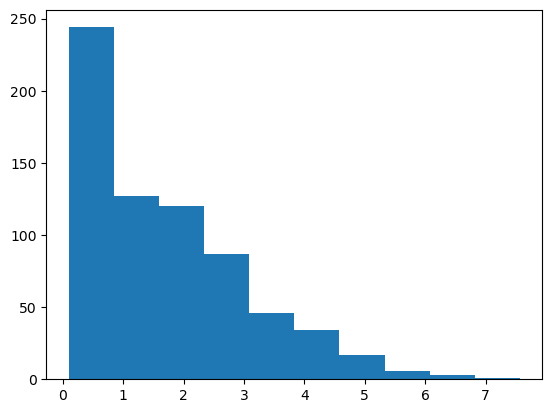

In [51]:
plt.hist(gaia_distances.kpc)

# number of stars near 4 kpc
np.sum((gaia_distances.kpc > 3.5) & (gaia_distances.kpc < 4.5))

Text(0.5, 1.0, 'Gaia DR3 sources near NGC 188')

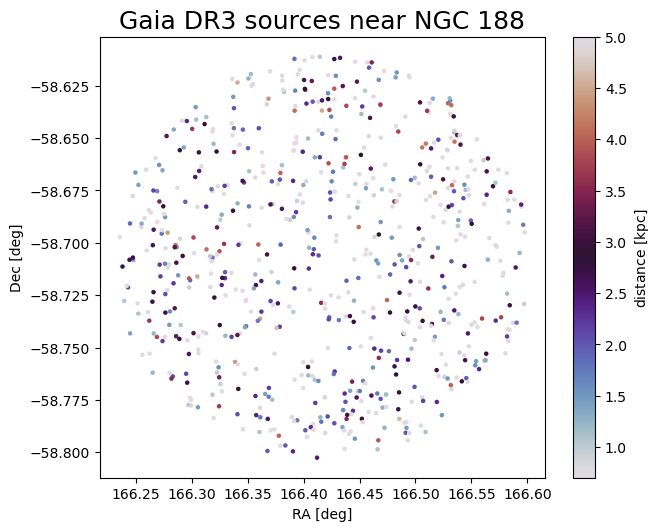

In [48]:
fig, ax = plt.subplots(figsize=(6.5, 5.2),
                       constrained_layout=True)
cs = ax.scatter(NGC3532_3d.ra.degree, 
                NGC3532_3d.dec.degree, 
                c=NGC3532_3d.distance.kpc, 
                s=5, vmin=0.7, vmax=5, cmap='twilight')
cb = fig.colorbar(cs)
cb.set_label(f'distance [{u.kpc:latex_inline}]')

ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')

ax.set_title('Gaia DR3 sources near NGC 188', fontsize=18)

In [49]:
g_mean_mag = NGC3532_Table['phot_g_mean_mag'] # in apparent magnitude
bp_rp = NGC3532_Table['bp_rp'] # in magnitude

# convert to absolute magnitude
g_abs_mag = g_mean_mag.value - 5 * np.log10(gaia_distances.value) + 5

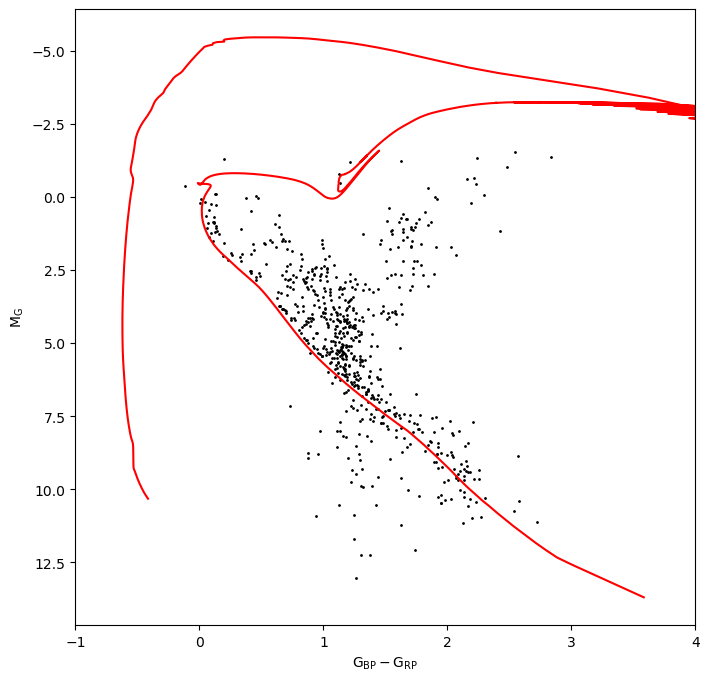

In [50]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 8))

# Plot the data
ax.scatter(bp_rp, g_abs_mag, s=1, color='black')

# Plot the MIST isochrones
scatter = ax.plot(B_R, V, color='red')


# ax.set_ylim(4, 20)
ax.invert_yaxis()
ax.set_xlim(-1, 4)

# Set labels
ax.set_xlabel(r'$\rm{G_{BP} - G_{RP}}$')
ax.set_ylabel(r'$\rm{M_G}$')

# plt.title('Scatter Plot with Square Root of Relative Density')
# plt.show()
plt.savefig('ASTR-400A-HWs/figs/HRD.png', dpi=150, bbox_inches='tight')
